In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import numpy as np

import sys
import os

from dataset import TrainDataset

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 384),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(
#             mean=(130.6546339553507, 84.802248113933, 80.22214275038328),
#             std=(14.45061680166957, 14.68356058416991, 13.664813135860628)
        ),
        ToTensorV2(),
    ]
)


test_transform = A.Compose(
    [
        A.Resize(256, 384),
        A.Normalize(
#             mean=(130.6546339553507, 84.802248113933, 80.22214275038328),
#             std=(14.45061680166957, 14.68356058416991, 13.664813135860628)
        ),
        ToTensorV2(),
    ]
)


def loader(path):
    with Image.open(path) as img:
        return np.asarray(img.convert('RGB'))

def apply_train(*a, **k):
    result = train_transform(*a, **k)
    return result

def apply_test(*a, **k):
    result = train_transform(*a, **k)
    return result

ds = TrainDataset(
    './LCAI2021/data_processed/train_set',
    input_shape = (3, 256, 384)
)

In [13]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [14]:
from efficientnet_pytorch.utils import GlobalParams
global_params = model._global_params
override_global_params = GlobalParams(
    width_coefficient=global_params.width_coefficient,
    depth_coefficient=global_params.depth_coefficient,
    image_size=global_params.image_size,
    dropout_rate=global_params.dropout_rate,
    num_classes=3,
    batch_norm_momentum=global_params.batch_norm_momentum,
    batch_norm_epsilon=global_params.batch_norm_epsilon,
    drop_connect_rate=global_params.drop_connect_rate,
    depth_divisor=global_params.depth_divisor,
    min_depth=global_params.min_depth,
    include_top=True,
)
model._global_params = override_global_params
model._fc = torch.nn.Linear(1792, 3)  # b4: 1792, b7: 2560

In [15]:
from torchinfo import summary
device = torch.device('cuda:1')
model.to(device)
summary(model, (32, 3, 256, 384), device=device)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       --                        --
├─ModuleList: 1-1                                  --                        --
├─Conv2dStaticSamePadding: 1-2                     [32, 48, 128, 192]        --
│    └─ZeroPad2d: 2-1                              [32, 3, 257, 385]         --
├─BatchNorm2d: 1-3                                 [32, 48, 128, 192]        96
├─MemoryEfficientSwish: 1-4                        [32, 48, 128, 192]        --
├─ModuleList: 1-1                                  --                        --
│    └─MBConvBlock: 2-2                            [32, 24, 128, 192]        --
│    │    └─Conv2dStaticSamePadding: 3-1           [32, 48, 128, 192]        432
│    │    └─BatchNorm2d: 3-2                       [32, 48, 128, 192]        96
│    │    └─MemoryEfficientSwish: 3-3              [32, 48, 128, 192]        --
│    │    └─Conv2dStaticSamePaddin

In [16]:
from easyrun import Easyrun

In [17]:
from torch.utils.data import random_split
import copy

tds, vds = random_split(ds, (int(len(ds) * 0.9), len(ds) - int(len(ds) * 0.9)))
train_indices = tds.indices
val_indices = vds.indices
tds = copy.deepcopy(ds)
vds = copy.deepcopy(ds)
tds.samples = [ds.samples[i] for i in train_indices]
vds.samples = [ds.samples[i] for i in val_indices]
tds.transform = train_transform
vds.transform = test_transform
tdl = DataLoader(tds, batch_size=64, num_workers=8, shuffle=True)
vdl = DataLoader(vds, batch_size=32, num_workers=8, shuffle=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
step_func = scheduler.step
epochs = 160

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


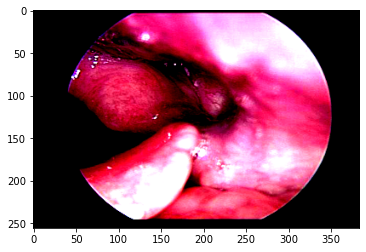

In [18]:
import matplotlib.pyplot as plt
plt.imshow(tds[1][0].permute(1, 2, 0).numpy())

In [ ]:
with Easyrun(
        model, 'CrossEntropyLoss', optimizer, epochs,
        tdl, vdl, None, log_interval=1, step_task=step_func,
        verbose=True, timer=True, snapshot_dir='.',
) as trainer:
    trainer.to(device)
    trainer()

In [21]:
ds.transform = apply_test
adl = DataLoader(ds, batch_size=32, num_workers=8, shuffle=False)
from sklearn.metrics import confusion_matrix
# cm = classification_confusion_matrix(model, adl, device=device)
# cm

array([[896,   3,   1],
       [  7, 890,   3],
       [  3,   1, 895]])

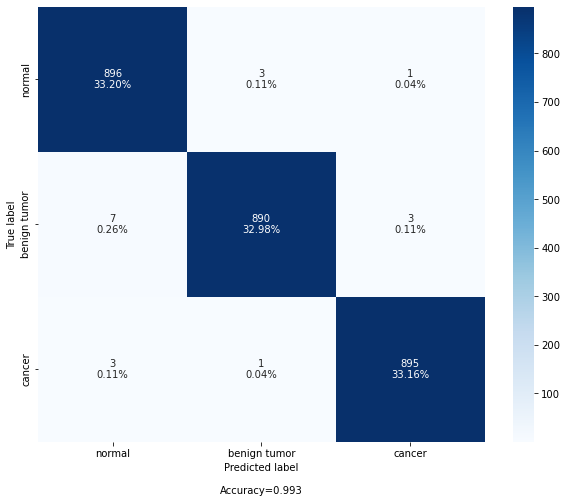

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# draw_confusion_matrix(cm, categories=['normal', 'benign tumor', 'cancer'], figsize=(10, 8))